1. 时序模型中，当前数据跟之前观察到的数据相关
2. 自回归模型使用自身过去数据来预测未来
3. 马尔可夫模型假设当前只跟最近少数数据相关，从而简化模型
4. 潜变量模型使用潜变量来概括历史信息

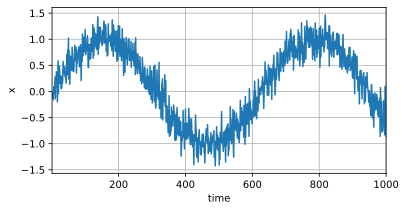

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6,3))

In [3]:
# 使用马尔可夫假设

# 只跟前4步有关
tau = 4

features = torch.zeros((T-tau, tau)) # torch.Size([996, 4])
for i in range(tau):
    features[:,i] = x[i: T - tau + i]
features.shape, features[0]

torch.Size([996, 4])

In [4]:
x.shape

torch.Size([1000])